Task 3: Energy Consumption Forecasting

Objective:
Forecast short-term household energy usage using historical patterns.

Dataset:
Household Power Consumption dataset

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import statsmodels.api as sm
from prophet import Prophet
import xgboost as xgb

In [2]:
df = pd.read_csv("household_power_consumption.txt", sep=";", low_memory=False)
df = df.replace("?", np.nan)

for col in df.columns[2:]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], format="%d/%m/%Y %H:%M:%S")
df = df.set_index("Datetime")
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,,,
2006-12-16 17:24:00,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


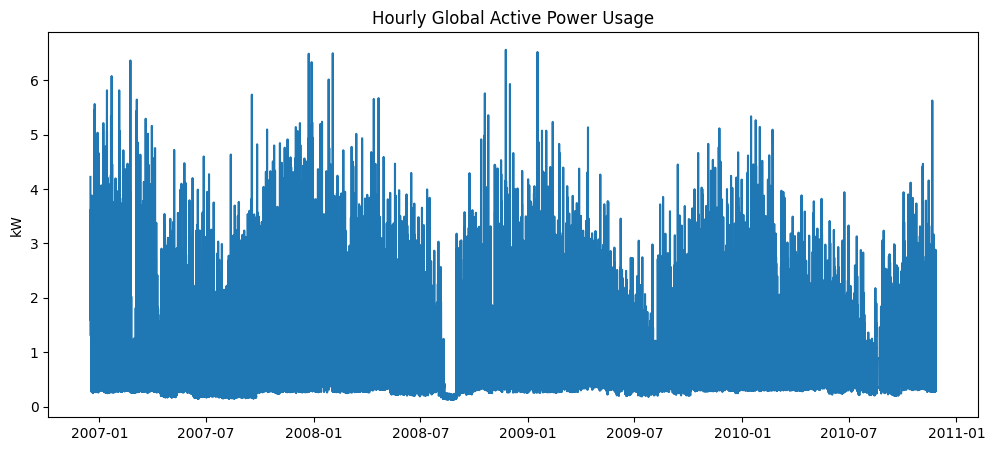

In [3]:
df["Global_active_power"] = df["Global_active_power"].astype(float)
data = df["Global_active_power"].resample("h").mean().ffill()

plt.figure(figsize=(12,5))
plt.plot(data)
plt.title("Hourly Global Active Power Usage")
plt.ylabel("kW")
plt.show()

In [4]:
df_features = pd.DataFrame(data)
df_features["hour"] = df_features.index.hour
df_features["dayofweek"] = df_features.index.dayofweek
df_features["month"] = df_features.index.month
df_features["is_weekend"] = (df_features["dayofweek"] >= 5).astype(int)
df_features.head()

,Global_active_power,hour,dayofweek,month,is_weekend
Datetime,,,,,
2006-12-16 17:00:00,4.222889,17,5,12,1
2006-12-16 18:00:00,3.632200,18,5,12,1
2006-12-16 19:00:00,3.400233,19,5,12,1
2006-12-16 20:00:00,3.268567,20,5,12,1
2006-12-16 21:00:00,3.056467,21,5,12,1


In [5]:
split = int(len(df_features) * 0.8)
train = df_features.iloc[:split]
test = df_features.iloc[split:]

train_y = train["Global_active_power"]
test_y = test["Global_active_power"]


ARIMA MAE: 0.7583783298154797
ARIMA RMSE: 0.8744507584777419


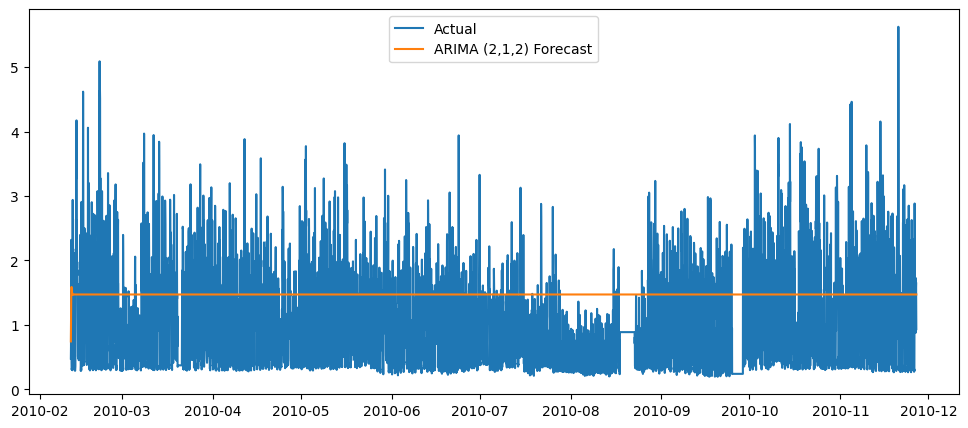

In [11]:
import warnings
warnings.filterwarnings("ignore")

arima_model = sm.tsa.ARIMA(train_y, order=(2,1,2))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test_y))

print("ARIMA MAE:", mean_absolute_error(test_y, arima_forecast))
print("ARIMA RMSE:", math.sqrt(mean_squared_error(test_y, arima_forecast)))

plt.figure(figsize=(12,5))
plt.plot(test_y.index, test_y, label="Actual")
plt.plot(test_y.index, arima_forecast, label="ARIMA (2,1,2) Forecast")
plt.legend()
plt.show()

10:31:30 - cmdstanpy - INFO - Chain [1] start processing
10:31:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAE: 0.4959171065508109
Prophet RMSE: 0.6461849620235088


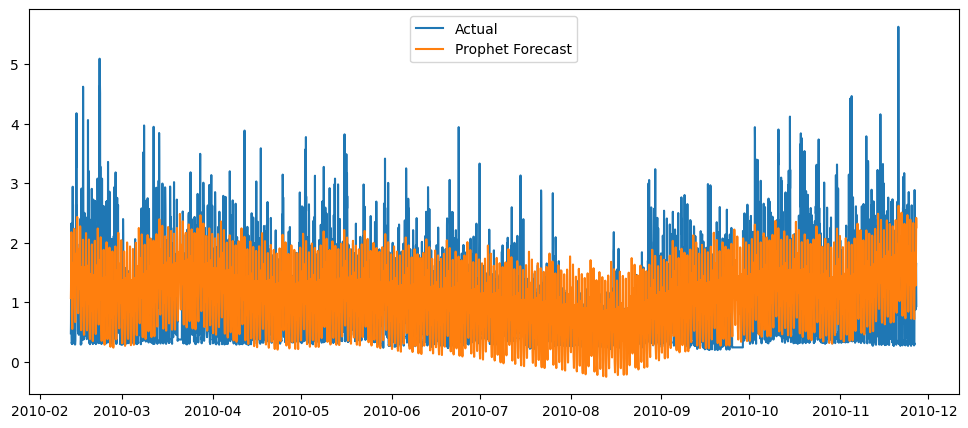

In [7]:
df_prophet = data.reset_index()
df_prophet = df_prophet.rename(columns={"Datetime": "ds", "Global_active_power": "y"})

train_p = df_prophet.iloc[:split]
test_p = df_prophet.iloc[split:]

prophet = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
prophet.fit(train_p)

future = prophet.make_future_dataframe(periods=len(test_p), freq="h")
forecast = prophet.predict(future)
prophet_forecast = forecast.set_index("ds")["yhat"].iloc[-len(test_p):]

print("Prophet MAE:", mean_absolute_error(test_y, prophet_forecast))
print("Prophet RMSE:", math.sqrt(mean_squared_error(test_y, prophet_forecast)))

plt.figure(figsize=(12,5))
plt.plot(test_y.index, test_y, label="Actual")
plt.plot(test_y.index, prophet_forecast, label="Prophet Forecast")
plt.legend()
plt.show()

XGBoost MAE: 0.3373920051527891
XGBoost RMSE: 0.4895192394185965


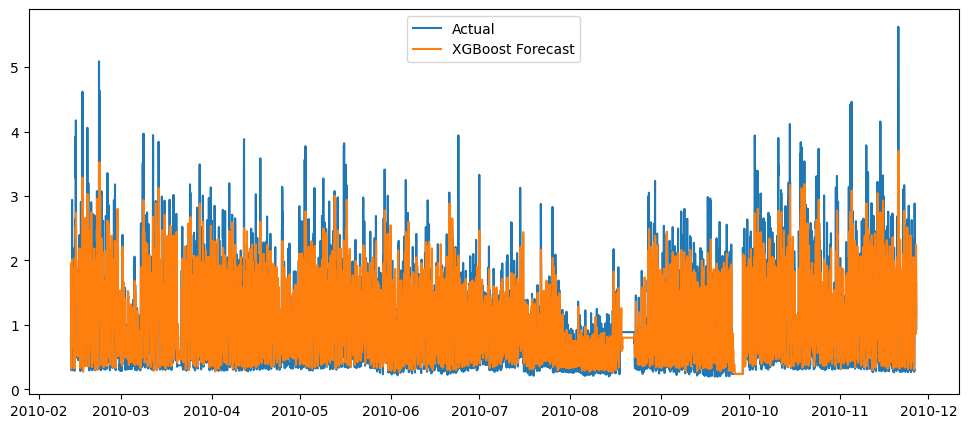

In [8]:
df_ml = pd.DataFrame(data)
for lag in range(1, 25):
    df_ml[f"lag_{lag}"] = df_ml["Global_active_power"].shift(lag)
df_ml = df_ml.dropna()

split_ml = int(len(df_ml) * 0.8)
X_train, X_test = df_ml.iloc[:split_ml, 1:], df_ml.iloc[split_ml:, 1:]
y_train, y_test = df_ml.iloc[:split_ml, 0], df_ml.iloc[split_ml:, 0]

xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("XGBoost RMSE:", math.sqrt(mean_squared_error(y_test, y_pred_xgb)))

plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred_xgb, label="XGBoost Forecast")
plt.legend()
plt.show()

              MAE      RMSE
ARIMA    0.758378  0.874451
Prophet  0.495917  0.646185
XGBoost  0.337392  0.489519


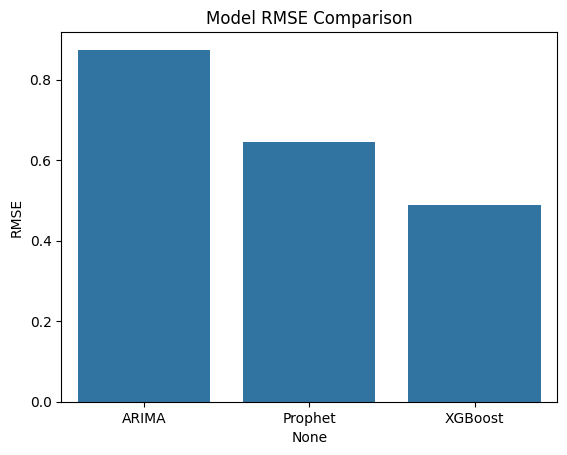

In [9]:
results = {
    "ARIMA": [mean_absolute_error(test_y, arima_forecast), math.sqrt(mean_squared_error(test_y, arima_forecast))],
    "Prophet": [mean_absolute_error(test_y, prophet_forecast), math.sqrt(mean_squared_error(test_y, prophet_forecast))],
    "XGBoost": [mean_absolute_error(y_test, y_pred_xgb), math.sqrt(mean_squared_error(y_test, y_pred_xgb))]
}
results_df = pd.DataFrame(results, index=["MAE", "RMSE"]).T
print(results_df)

sns.barplot(x=results_df.index, y=results_df["RMSE"])
plt.title("Model RMSE Comparison")
plt.show()